# Counterfeit detection

The task in this assignment is to detect the  counterfeit banknotes. The data set is based on [banknote authentication Data Set ](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#) from UCI Machine Learning repository. The first three columns denote different parameters obtained from the photographs of the banknotes and last colum provides the label. Frankly as the dataset does not have any description I don't know  which labels corresponds to real and which to counterfeited banknotes. let's assume that label one (positive) denotes the clounterfeits. The set  "banknote_authentication.csv" can be found in the data  directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scrapbook as sb

In [2]:
sb.glue('person1',['Mariusz', 'Kluza'], display=True)
sb.glue('person2',['Mikołaj', 'Migut'], display=True)

['Mariusz', 'Kluza']

['Mikołaj', 'Migut']

In [3]:
data = pd.read_csv('data/banknote_authentication.csv')

In [4]:
data.head()

,a1,a2,a3,counterfeit
0,12.3784,0.70403,-7.58360,0
1,8.1881,-3.13380,-2.52760,0
2,-10.8679,9.49260,-1.41160,1
3,-8.7903,7.97350,-0.45475,1
4,-5.5167,10.93900,-0.40820,1


In [5]:
data.describe()

,a1,a2,a3,counterfeit
count,1097.000000,1097.000000,1097.000000,1097.000000
mean,1.805698,1.488454,-1.177636,0.444850
std,5.936574,4.403893,2.073943,0.497176
min,-13.773100,-5.286100,-7.871900,0.000000
25%,-2.090000,-1.628300,-2.342700,0.000000
50%,2.290700,0.614060,-0.591820,0.000000
75%,6.756200,3.395400,0.399980,1.000000
max,12.730200,17.927400,2.449500,1.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   a1           1097 non-null   float64
 1   a2           1097 non-null   float64
 2   a3           1097 non-null   float64
 3   counterfeit  1097 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 34.4 KB


## Problem 

### A.

Perform the Quadratic Discriminant Analysis on this set. Calculate the confusion matrix, AUC score and plot the ROC curve. Please use `scrapbook` to store your results. 

also please save the ROC plot

In [7]:
from sklearn.model_selection import train_test_split
seed = 2137
data_train, data_test = train_test_split(data, test_size=0.2, stratify=data['counterfeit'], random_state=seed)

In [8]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()

qda.fit(data_train.loc[:,'a1' : 'a3'], data_train['counterfeit']) 

QuadraticDiscriminantAnalysis()

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score

test_proba = qda.predict_proba(data_test.loc[:,'a1':'a3'])[:,1]
fprs, tprs, thds = roc_curve(data_test['counterfeit'], test_proba)
auc = roc_auc_score(data_test['counterfeit'], test_proba)
tnr, fpr, fnr, tpr = confusion_matrix(data_test['counterfeit'], test_proba>0.5, normalize='true').ravel()
f1_score_ = f1_score(data_test['counterfeit'], test_proba>0.5)
precision = precision_score(data_test['counterfeit'], test_proba>0.5)
sb.glue('B_scores',[tnr, fpr, fnr, tpr, precision, f1_score_, auc], display=True)

[0.8360655737704918,
 0.16393442622950818,
 0.23469387755102042,
 0.7653061224489796,
 0.7894736842105263,
 0.7772020725388602,
 0.8670960187353629]

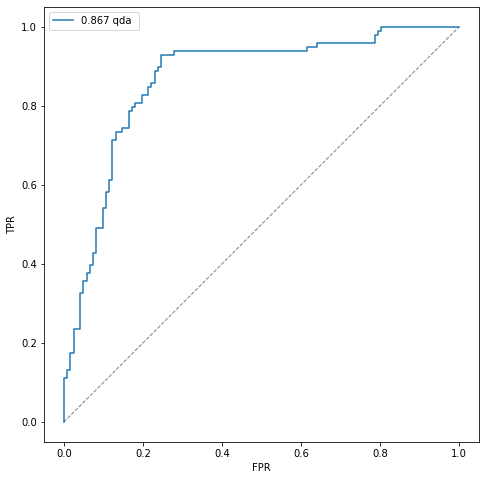

In [10]:
from mchlearn.plotting import roc_plot, add_roc_curve

fig, ax = roc_plot()
add_roc_curve(data_test['counterfeit'], test_proba, name='qda', ax=ax)
ax.legend()
sb.glue('A_ROC',fig, "display", display=False)

### B.

Perform Gaussian Mixture Discriminant Analysis on this set as described in the `gaussian_mixture_model_EM_algorithm` notebook. Use two components for positives and two components for negatives. Calculate the confusion matrix, AUC score and plot the ROC curve. 

also please save the ROC plot

In [11]:
from sklearn.mixture import GaussianMixture

real_train = data_train[data_train['counterfeit']==0]
counterfeit_train = data_train[data_train['counterfeit']==1]

In [12]:
def make_pdf(cmp):
    n_cmp = cmp.n_components
    dists = [st.multivariate_normal(cmp.means_[i], cmp.covariances_[i]) for i in range(n_cmp)]
    def pdf(x):
        p = 0.0
        for i in range(n_cmp):
            p+= cmp.weights_[i]*dists[i].pdf(x)
        return p
    return pdf

In [13]:
def make_predict_proba(cmp0, cmp1, pi1=0.5):
    pi0 = 1 - pi1
    pdf0 = make_pdf(cmp0)
    pdf1 = make_pdf(cmp1)
    
    def p(x):
        p0 = pi0*pdf0(x)
        p1 = pi1*pdf1(x)
        return p1/(p1+p0)
    return p

In [14]:
gm0 = GaussianMixture(n_components=2)
gm1 = GaussianMixture(n_components=2)

In [15]:
gm0.fit(real_train.loc[:,'a1':'a3'])
gm1.fit(counterfeit_train.loc[:,'a1':'a3'])

GaussianMixture(n_components=2)

In [16]:
mgda = make_predict_proba(gm0, gm1, pi1=0.44)

mgda_test_proba = mgda(data_test.loc[:,'a1':'a3'])
mgda_fprs, mgda_tprs, mgda_thds = roc_curve(data_test['counterfeit'], mgda_test_proba)
mgda_auc = roc_auc_score(data_test['counterfeit'], mgda_test_proba)
mgda_tnr, mgda_fpr, mgda_fnr, mgda_tpr = confusion_matrix(data_test['counterfeit'], mgda_test_proba>0.5, normalize='true').ravel()
mgda_f1_score = f1_score(data_test['counterfeit'], mgda_test_proba>0.5)
mgda_precision = precision_score(data_test['counterfeit'], mgda_test_proba>0.5)
sb.glue('B_scores',[mgda_tnr, mgda_fpr, mgda_fnr, mgda_tpr, mgda_precision, mgda_f1_score, mgda_auc], display=True)

[0.9672131147540983,
 0.03278688524590164,
 0.12244897959183673,
 0.8775510204081632,
 0.9555555555555556,
 0.9148936170212767,
 0.9667112746738039]

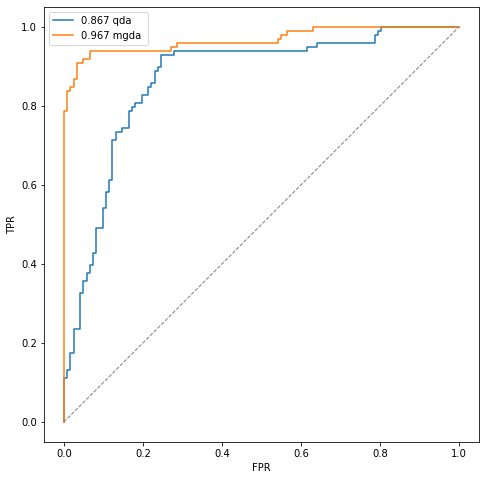

In [17]:
fig, ax = roc_plot()
add_roc_curve(data_test['counterfeit'], test_proba, name='qda', ax=ax)
add_roc_curve(data_test['counterfeit'], mgda_test_proba, name='mgda', ax=ax)
ax.legend()
sb.glue('B_ROC',fig, "display", display=False)

### C.

Use k-fold cross validation to find the optimal number of gaussian components for each class. As before calculate the confusion matrix, AUC score and plot the ROC curve for the best classifier. 

__Hint__ use the `StratifiedKFold` function from scikit-learn library to generate folds. 

Store the results for the best estimator

also please save the ROC plot

In [18]:
def run(n_cmp0, n_cmp1, train, test, pi):
    gm0 = GaussianMixture(n_components=n_cmp0)
    gm1 = GaussianMixture(n_components=n_cmp1)
    gm0.fit(train[train[:,-1]==0][:,:-1])
    gm1.fit(train[train[:,-1]==1][:,:-1])
    mga = make_predict_proba(gm0, gm1, pi1=pi)
    proba_test = mga(test[:,:-1])
    return f1_score(test[:,-1], proba_test>0.5)

In [19]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)
n_range = (3, 40)
nl = n_range[1]-n_range[0]
mat = np.zeros( (nl, nl))

for n0 in range(*n_range):
    for n1 in range(*n_range):
        f1 = 0.0
        for train_index, test_index in skf.split(data_train.loc[:, 'a1':'a3'], data_train['counterfeit']):
            f1 += run(n0, n1, data_train.values[train_index][:,1:], data_train.values[test_index][:,1:], 0.44)
        mat[n0-n_range[0], n1-n_range[0]]=f1/5
        

In [20]:
pd.DataFrame(mat, index = range(*n_range), columns=range(*n_range))

,3,4,5,6,7,8,9,10,11,12,...,30,31,32,33,34,35,36,37,38,39
3,0.440846,0.470903,0.458166,0.502610,0.553107,0.557666,0.571768,0.552508,0.570517,0.576014,...,0.566717,0.580202,0.556341,0.551711,0.558201,0.567859,0.579607,0.579720,0.581158,0.576771
4,0.500143,0.544745,0.558901,0.555440,0.583789,0.578369,0.582607,0.607193,0.602407,0.610175,...,0.599851,0.585430,0.594905,0.591029,0.616352,0.589741,0.598256,0.600492,0.598814,0.590135
5,0.549688,0.523104,0.570680,0.601499,0.565879,0.617478,0.611266,0.598925,0.630885,0.601480,...,0.615223,0.634241,0.585369,0.575000,0.620266,0.603070,0.627997,0.601249,0.593915,0.589002
6,0.559077,0.570781,0.580491,0.581754,0.597290,0.587514,0.578769,0.623235,0.621124,0.613893,...,0.625510,0.609897,0.613382,0.611875,0.611378,0.619744,0.621517,0.593259,0.593494,0.574636
7,0.578420,0.565852,0.596788,0.591148,0.594041,0.614539,0.602670,0.617364,0.614846,0.624501,...,0.609911,0.636985,0.611991,0.596142,0.629376,0.629604,0.608985,0.613676,0.646223,0.587493
8,0.572872,0.569484,0.597808,0.623523,0.592080,0.597882,0.623457,0.610953,0.637452,0.605844,...,0.614480,0.605060,0.623050,0.611308,0.592840,0.631949,0.614994,0.614224,0.609711,0.592275
9,0.588993,0.591692,0.615027,0.582816,0.630905,0.592699,0.625002,0.622307,0.601338,0.625221,...,0.613836,0.645865,0.621138,0.625851,0.627871,0.620283,0.628443,0.600441,0.607498,0.584898
10,0.591833,0.605205,0.618259,0.610675,0.606550,0.629216,0.617675,0.597738,0.632303,0.633132,...,0.637031,0.617051,0.648575,0.618879,0.619619,0.613541,0.631028,0.620852,0.618545,0.618700
11,0.590700,0.605399,0.598326,0.581843,0.613780,0.595665,0.617978,0.620106,0.620145,0.627149,...,0.605294,0.637282,0.626399,0.608173,0.621211,0.638514,0.596651,0.611453,0.642920,0.621454
12,0.594490,0.597133,0.607920,0.613604,0.625136,0.614693,0.611379,0.629327,0.642775,0.631723,...,0.626997,0.608360,0.638786,0.621114,0.645173,0.649271,0.627893,0.619907,0.648766,0.616830


In [21]:
opt_n_cmp= np.asarray(np.unravel_index(np.argmax(mat), mat.shape))+(n_range[0], n_range[0])
print(opt_n_cmp)

[35 24]


In [22]:
gm0_opt = GaussianMixture(n_components=opt_n_cmp[0])
gm1_opt = GaussianMixture(n_components=opt_n_cmp[1])

gm0_opt.fit(real_train.loc[:, 'a1':'a3'])
gm1_opt.fit(counterfeit_train.loc[:, 'a1':'a3'])

GaussianMixture(n_components=24)

In [23]:
mgda_opt = make_predict_proba(gm0_opt, gm1_opt, pi1=0.44)

mgda_opt_test_proba = mgda_opt(data_test.loc[:,'a1':'a3'])
mgda_opt_fprs, mgda_opt_tprs, mgda_opt_thds = roc_curve(data_test['counterfeit'], mgda_opt_test_proba)
mgda_opt_auc = roc_auc_score(data_test['counterfeit'], mgda_opt_test_proba)
mgda_opt_tnr, mgda_opt_fpr, mgda_opt_fnr, mgda_opt_tpr = confusion_matrix(data_test['counterfeit'], mgda_opt_test_proba>0.5, normalize='true').ravel()
mgda_opt_f1_score = f1_score(data_test['counterfeit'], mgda_opt_test_proba>0.5)
mgda_opt_precision = precision_score(data_test['counterfeit'], mgda_opt_test_proba>0.5)
sb.glue('C_scores',[mgda_opt_tnr, mgda_opt_fpr, mgda_opt_fnr, mgda_opt_tpr, mgda_opt_precision, mgda_opt_f1_score, mgda_opt_auc], display=True)

[0.9672131147540983,
 0.03278688524590164,
 0.04081632653061224,
 0.9591836734693877,
 0.9591836734693877,
 0.9591836734693877,
 0.9940615590498494]

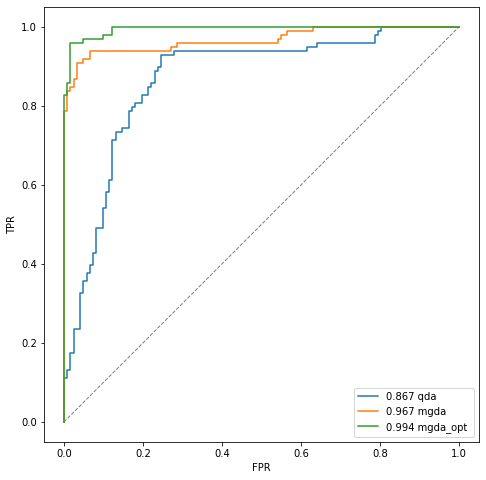

In [24]:
fig, ax = roc_plot()
add_roc_curve(data_test['counterfeit'], test_proba, name='qda', ax=ax)
add_roc_curve(data_test['counterfeit'], mgda_test_proba, name='mgda', ax=ax)
add_roc_curve(data_test['counterfeit'], mgda_opt_test_proba, name='mgda_opt', ax=ax)
ax.legend()
sb.glue('C_ROC',fig, "display", display=False)

## D.  

Assume that 1% of all the customers in your store presents a counterfeit 100PLN bill. If you accept the counterfeit bill you loose 100PLN. If you reject a valid bill,  you may loose the purchase, you estimate this loss as 15PLN on average. For each of the three classifiers find the threshold that minimises your losses and calculates the minimum loss for each classifier. Show the optimal classifiers points on the ROC curves.

In [25]:
def calculate_score(fpr, fnr):
    return fnr * 0.01 * 100 + fpr * 0.01 * 15


def calculate_optimal(fprs,tprs,thds):
    min_loss = 1
    index = 0
    for i, _ in enumerate(thds):
            s=calculate_score(fprs[i], 1-tprs[i])
            if (s<min_loss):
                min_loss=s
                index=i
    tnr = 1 - fprs[index]
    fpr = fprs[index]
    fnr = 1 - tprs[index]
    tpr = tprs[index]
    thres = thds[index]
    prec = precision_score(data_test['counterfeit'], test_proba>thres)
    f1 = f1_score(data_test['counterfeit'], test_proba>thres)
    auc = roc_auc_score(data_test['counterfeit'], test_proba)
    return tnr, fpr, fnr, tpr, prec, f1, auc, min_loss, thres

In [26]:
tnr, fpr, fnr, tpr, precision, f1, auc, min_loss, threshold = calculate_optimal(fprs,tprs,thds)
sb.glue('D_A_scores',[tnr, fpr, fnr, tpr, precision, f1, auc, min_loss, threshold], display=True)

[0.7213114754098361,
 0.2786885245901639,
 0.061224489795918324,
 0.9387755102040817,
 0.728,
 0.8161434977578476,
 0.8670960187353629,
 0.10302776848444291,
 0.16916593822909295]

In [27]:
mgda_tnr, mgda_fpr, mgda_fnr, mgda_tpr, mgda_precision, mgda_f1, mgda_auc, mgda_min_loss, mgda_threshold = calculate_optimal(mgda_fprs,mgda_tprs,mgda_thds)
sb.glue('D_B_scores',[mgda_tnr, mgda_fpr, mgda_fnr, mgda_tpr, mgda_precision, mgda_f1, mgda_auc, mgda_min_loss, mgda_threshold], display=True)

[0.9344262295081968,
 0.06557377049180328,
 0.061224489795918324,
 0.9387755102040817,
 0.7545454545454545,
 0.7980769230769231,
 0.8670960187353629,
 0.07106055536968882,
 0.3346010935702068]

In [28]:
mgda_opt_tnr, mgda_opt_fpr, mgda_opt_fnr, mgda_opt_tpr, mgda_opt_precision, mgda_opt_f1, mgda_opt_auc, mgda_opt_min_loss, mgda_opt_threshold = calculate_optimal(mgda_opt_fprs,mgda_opt_tprs,mgda_opt_thds)
sb.glue('D_C_scores',[mgda_opt_tnr, mgda_opt_fpr, mgda_opt_fnr, mgda_opt_tpr, mgda_opt_precision, mgda_opt_f1, mgda_opt_auc, mgda_opt_min_loss, mgda_opt_threshold], display=True)

[0.8770491803278688,
 0.12295081967213115,
 0.0,
 1.0,
 0.5679012345679012,
 0.7076923076923076,
 0.8670960187353629,
 0.018442622950819675,
 0.031164375537061462]

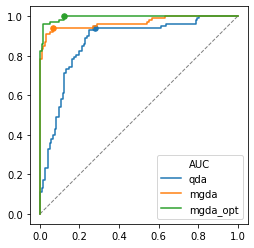

In [29]:
fig, ax = plt.subplots()
ax.set_aspect(1)
ax.plot([0, 1], [0, 1], linewidth=1, linestyle='--', color='grey')
ax.plot(fprs, tprs, label="qda")
ax.scatter([fpr],[tpr], s = 30)
ax.plot(mgda_fprs, mgda_tprs, label="mgda")
ax.scatter([mgda_fpr],[mgda_tpr], s = 30)
ax.plot(mgda_opt_fprs, mgda_opt_tprs, label="mgda_opt")
ax.scatter([mgda_opt_fpr],[mgda_opt_tpr], s = 30)

ax.legend(title='AUC')
sb.glue('D_ROC',fig, "display", display=False)